In [1]:
import re
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

import warnings

plt.style.use("default")
plt.rcParams['font.sans-serif'] = ['SimHei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False     # 用来正常显示负号
warnings.filterwarnings("ignore")               # 忽略警告
os.makedirs("./output",exist_ok=True)          # 文件配置

In [15]:
# 导入数据

series = pd.read_csv("./yiyao300.csv",encoding="UTF-8",index_col="Date",parse_dates=["Date"]).Open
data = series.resample("W").mean().bfill()
data.isna().sum()

0

In [21]:
series

Date
2014-01-02     5743.64
2014-01-03     5851.38
2014-01-06     5796.30
2014-01-07     5619.79
2014-01-08     5730.28
                ...   
2021-04-26    17232.34
2021-04-27    17005.88
2021-04-28    17435.99
2021-04-29    17787.96
2021-04-30    17748.70
Name: Open, Length: 1781, dtype: float64

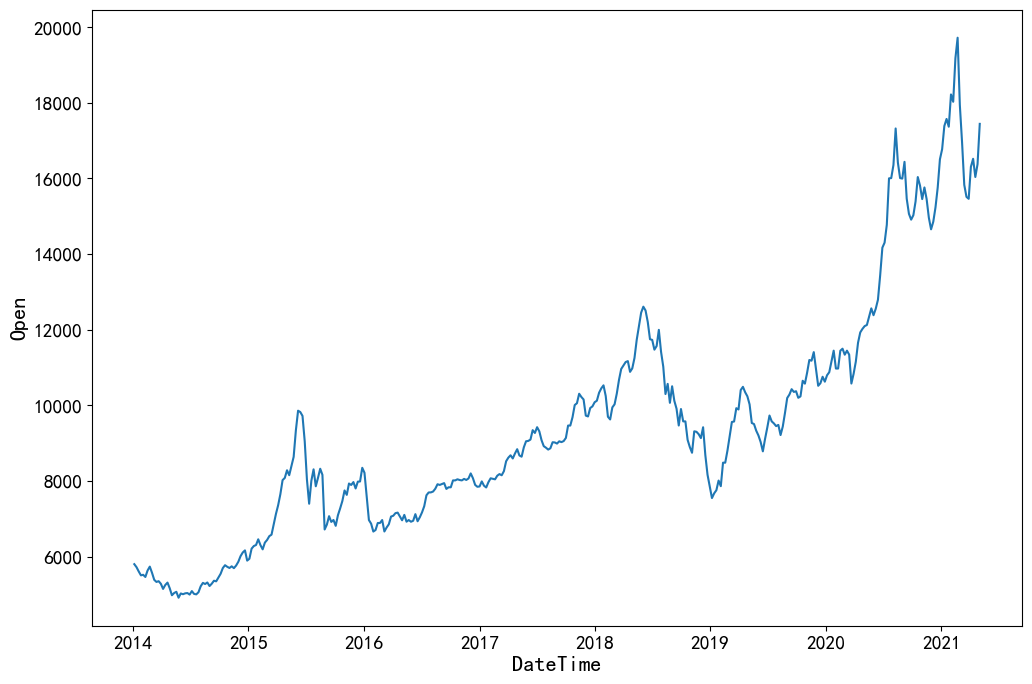

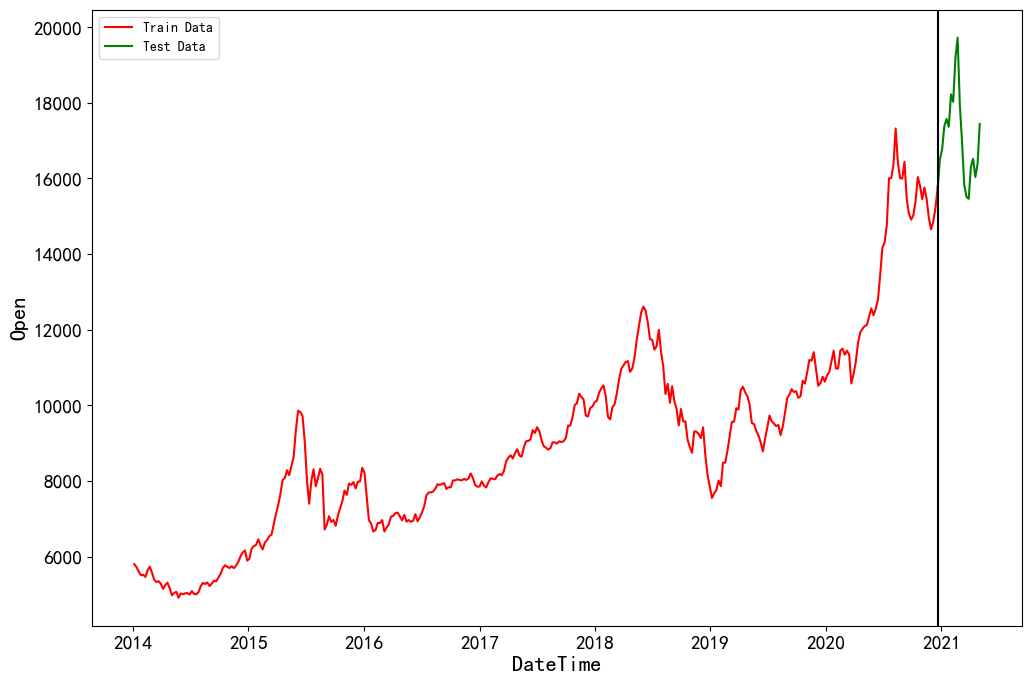

In [4]:
# 绘制时序图
fig = plt.figure(figsize=(12,8))
plt.plot(data)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("DateTime", fontsize = 16)
plt.ylabel("Open", fontsize = 16)
plt.savefig("output/TimeSeries.png", dpi = 500, format = "png", bbox_inches = "tight")
plt.show()


# 重采样
#划分训练集
index = data.index[int(len(data)*0.95)]
train_data = data[:int(len(data)*0.95)+1]
test_data = data[int(len(data)*0.95):]

#可视化
# 绘制时序图
fig = plt.figure(figsize=(12,8))
plt.plot(train_data,"r",label="Train Data")
plt.plot(test_data,"g",label="Test Data")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("DateTime", fontsize = 16)
plt.ylabel("Open", fontsize = 16)
plt.axvline(x=index,ls="-",c="black")#添加垂直直线
plt.legend(loc="best")
plt.savefig("output/TimeSeries2.png", dpi = 500, format = "png", bbox_inches = "tight")
plt.show()

当绘制数据的时间序列图，可以发现时间序列具有明显的季节性模式，故需要第ARIMA进行时间序列预测

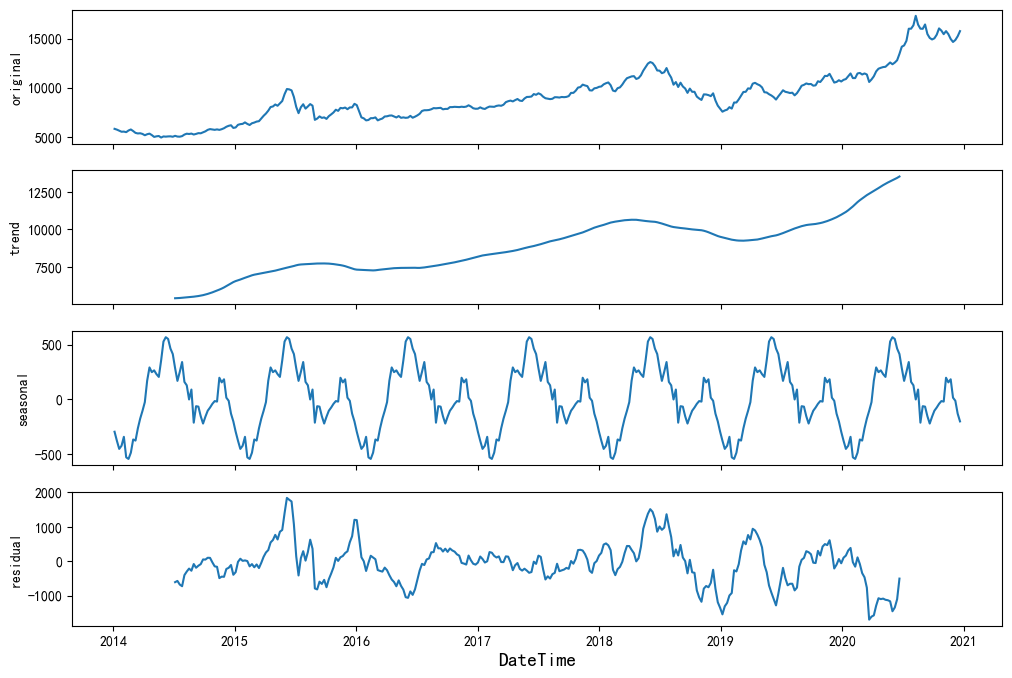

In [5]:
# 季节性分解
decomposition = seasonal_decompose(train_data)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig,axes = plt.subplots(4,1,sharex=True,figsize=(12,8))
axes[0].plot(train_data)
axes[0].set_ylabel("original")
axes[1].plot(trend)
axes[1].set_ylabel("trend")
axes[2].plot(seasonal)
axes[2].set_ylabel("seasonal")
axes[3].plot(residual)
axes[3].set_ylabel("residual")
plt.xlabel("DateTime",fontsize=14)
plt.subplots_adjust(hspace=0.2)
plt.savefig("output/decomposition.png", dpi = 500, format = "png", bbox_inches = "tight")
plt.show()

# 同时可以使用seasonal_decompose函数进行分析，可以看出季节性非常明显
# 残差值实际上取消了数据的趋势和季节性，使得这些值与时间无关。可以尝试使用外生变量来对残差进行建模，
# 但是如果尝试将预测的残差值转换回有意义的数值，可能会非常棘手。



In [6]:
#数据平稳性检测
# 用Dickey-Fuller test检验序列是否平稳
def judge_stationarity(data_sanya_one):
    dftest = ts.adfuller(data_sanya_one)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    stationarity = "是"
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
        if dftest[0] > value:
                stationarity = "否"
    print(dfoutput)
    print("是否平稳(是/否): %s" %(stationarity))
    return stationarity
stationarity = judge_stationarity(train_data)

Test Statistic                   0.043735
p-value                          0.962003
#Lags Used                       5.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64
是否平稳(是/否): 否


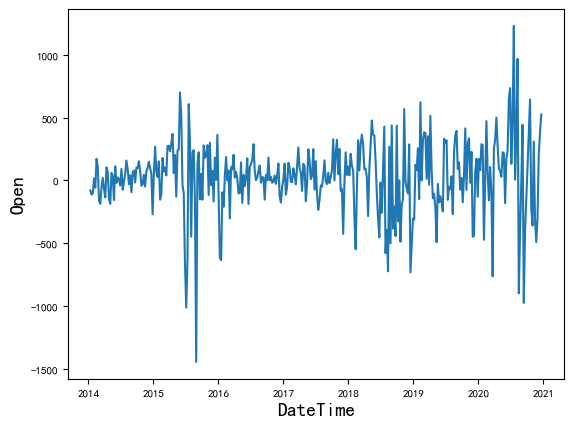

Test Statistic                -9.307411e+00
p-value                        1.071488e-15
#Lags Used                     4.000000e+00
Number of Observations Used    3.580000e+02
Critical Value (1%)           -3.448749e+00
Critical Value (5%)           -2.869647e+00
Critical Value (10%)          -2.571089e+00
dtype: float64
是否平稳(是/否): 是


In [7]:
# 季节差分

differenced = train_data.diff(1).dropna()

plt.plot(differenced)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel("DateTime", fontsize = 14)
plt.ylabel("Open", fontsize = 14)
plt.savefig("output/SeasonDiff.png", dpi = 500, format = "png", bbox_inches = "tight")
plt.show()
stationarity = judge_stationarity(differenced)


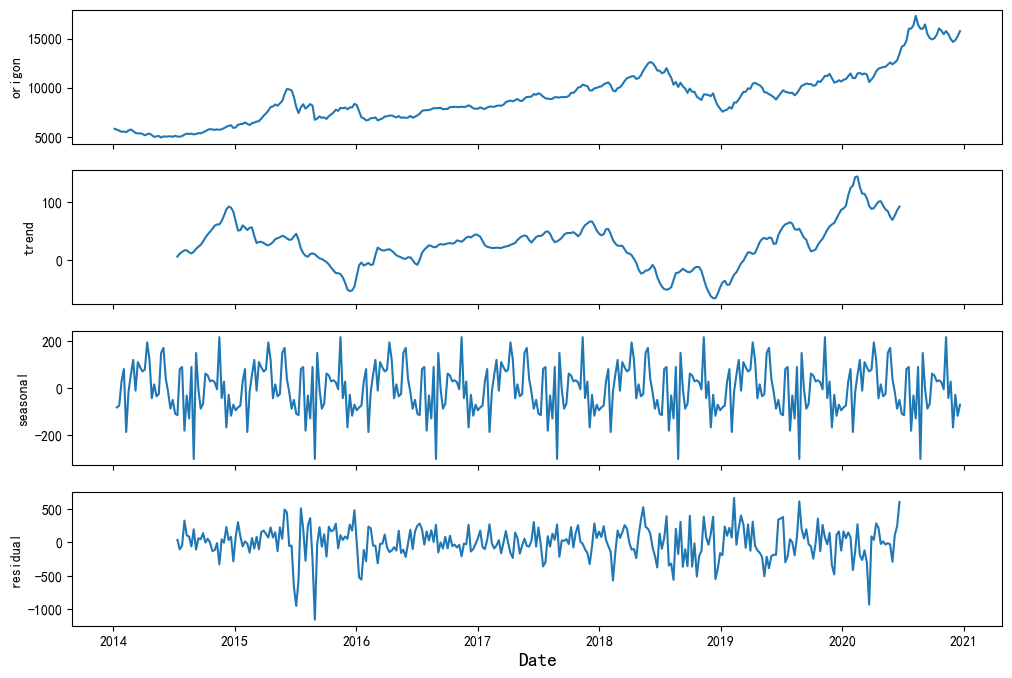

In [8]:
# 季节性分解
decomposition = seasonal_decompose(differenced)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig,axes = plt.subplots(4,1,sharex=True,figsize=(12,8))
axes[0].plot(train_data)
axes[0].set_ylabel("origon")
axes[1].plot(trend)
axes[1].set_ylabel("trend")
axes[2].plot(seasonal)
axes[2].set_ylabel("seasonal")
axes[3].plot(residual)
axes[3].set_ylabel("residual")
plt.xlabel("Date",fontsize=14)
plt.subplots_adjust(hspace=0.2)
plt.savefig("output/decomposition2.png", dpi = 500, format = "png", bbox_inches = "tight")

plt.show()
# 同时可以使用seasonal_decompose函数进行分析，可以看出季节性非常明显
# 残差值实际上取消了数据的趋势和季节性，使得这些值与时间无关。可以尝试使用外生变量来对残差进行建模，
# 但是如果尝试将预测的残差值转换回有意义的数值，可能会非常棘手。

In [9]:
'''acorr_ljungbox(x, lags=None, boxpierce=False)函数检验无自相关
lags为延迟期数，如果为整数，则是包含在内的延迟期数，如果是一个列表或数组，那么所有时滞都包含在列表中最大的时滞中
boxpierce为True时表示除开返回LB统计量还会返回Box和Pierce的Q统计量
返回值：
lbvalue:测试的统计量
pvalue:基于卡方分布的p统计量
bpvalue:((optionsal), float or array) – test statistic for Box-Pierce test
bppvalue:((optional), float or array) – p-value based for Box-Pierce test on chi-square distribution
'''
r,q,p = sm.tsa.acf(differenced.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
test_stochastic1 = round(table.set_index('lag'),3)
test_stochastic1

# def test_stochastic(ts,lag):
#     p_value = acorr_ljungbox(ts, lags=lag, boxpierce=False) #lags可自定义
#     return pd.DataFrame(p_value,index=("Test Value","P Value")).T
# test_stochastic1 = test_stochastic(differenced,24)
# test_stochastic1

# 从上面的分析结果中可以看到，延迟6阶的p值为<0.05，因此可以拒绝原假设，认为该序列不是白噪声序列。

,AC,Q,Prob(>Q)
lag,,,
1.0,0.213,16.638,0.000
2.0,0.044,17.334,0.000
3.0,0.006,17.347,0.001
4.0,0.051,18.298,0.001
5.0,-0.165,28.423,0.000
6.0,-0.011,28.471,0.000
7.0,0.039,29.030,0.000
8.0,0.029,29.341,0.000
9.0,0.045,30.094,0.000


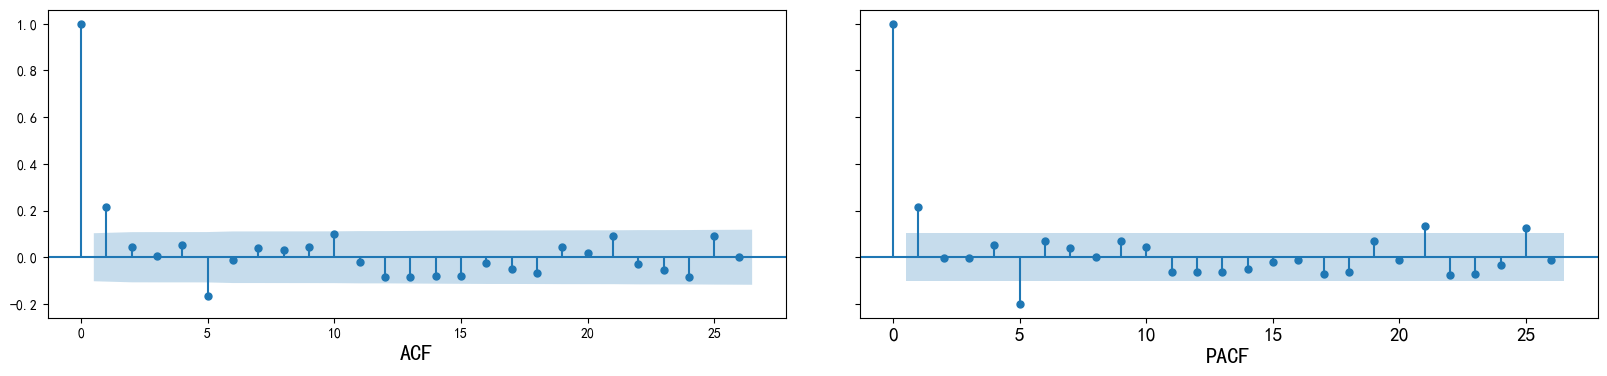

In [10]:
#查看acf与pacf确定q和p
fig, axes = plt.subplots(1,2, sharey=True,figsize = (20,4))
plot_acf(differenced, ax=axes[0])
plot_pacf(differenced, ax=axes[1])
axes[0].set_xlabel("ACF",fontsize=16)
axes[0].set_title("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axes[1].set_xlabel("PACF",fontsize=16)
axes[1].set_title("")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.subplots_adjust(wspace=0.1)
plt.savefig("./output/acf_pacf.png",dpi=500, bbox_inches = "tight")
plt.show()

In [11]:
# 定阶
#在statsmodels包里还有更直接的函数：
order = ts.arma_order_select_ic(differenced,max_ar=3,max_ma=3,ic=['aic', 'bic', 'hqic'])

orderAIC = pd.melt(order["aic"].reset_index(), id_vars=["index"]).rename(columns = {"index":"AR","variable":"MA","value":"AIC"})
orderBIC = pd.melt(order["bic"].reset_index(), id_vars=["index"]).rename(columns = {"index":"AR","variable":"MA","value":"BIC"})
orderHQIC = pd.melt(order["hqic"].reset_index(), id_vars=["index"]).rename(columns = {"index":"AR","variable":"MA","value":"HQIC"})
orderAIC["order"] = "ARMA(" + orderAIC["AR"].astype(str) +"," + orderBIC["MA"].astype(str) + ")"
orderBIC["order"] = "ARMA(" + orderAIC["AR"].astype(str) +"," + orderBIC["MA"].astype(str) + ")"
orderHQIC["order"] = "ARMA(" + orderAIC["AR"].astype(str) +"," + orderBIC["MA"].astype(str) + ")"
orderAIC.drop(["AR","MA"],axis=1,inplace=True)
orderBIC.drop(["AR","MA"],axis=1,inplace=True)
orderHQIC.drop(["AR","MA"],axis=1,inplace=True)

print(order.aic_min_order)
print(order.bic_min_order)
print(order.hqic_min_order)

orderdf = orderAIC.merge(orderBIC,on="order").merge(orderHQIC,on="order")
order_result = round(orderdf[["order","AIC","BIC","HQIC"]],3)


(1, 2)
(1, 0)
(1, 0)


In [13]:
mod = sm.tsa.ARIMA(train_data,order=(0, 1, 2))
model = mod.fit()
result_df = model.summary()
table1 = pd.DataFrame(result_df.tables[0])
table2 = pd.DataFrame(result_df.tables[1])
table3 = pd.DataFrame(result_df.tables[2])

result_df

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Open   No. Observations:                  363
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2556.174
Method:                       css-mle   S.D. of innovations            276.662
Date:                Thu, 06 Oct 2022   AIC                           5120.348
Time:                        11:44:31   BIC                           5135.926
Sample:                    01-12-2014   HQIC                          5126.540
                         - 12-20-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27.6953     18.294      1.514      0.130      -8.160      63.551
ma.L1.D.Open     0.2166      0.053      4.077      0.000       0.112       0.321
ma.L2.D.Open     0.0440      0.046      0.954      0.340      -0.046       0.134
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.4600           -4.0817j            4.7657           -0.3363
MA.2           -2.4600           +4.0817j            4.7657            0.3363
-----------------------------------------------------------------------------
"""

In [15]:
# # 自动定阶

# pdq = list(itertools.product(range(0,3), range(0,2), range(0,3)))
# seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(pdq)]

# results = {}
# modelpara,AIC,BIC,HQIC = [],[],[],[]
# for param_seasonal in seasonal_pdq:
#     try:
#         mod = sm.tsa.statespace.SARIMAX(train_data,
#                                         order=(1,1,2),
#                                         seasonal_order=param_seasonal,
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False).fit()
#         modelpara.append("ARIMA(1,1,2)x{}".format(param_seasonal))
#         AIC.append(mod.aic)
#         BIC.append(mod.bic)
#         HQIC.append(mod.hqic)
#         print('ARIMA{}x{} - AIC:{} - BIC:{} - HQIC:{}'.format(param, param_seasonal, mod.aic,mod.bic,mod.hqic))
#     except:
#         continue
        
# results["ARIMA"] = modelpara
# results["AIC"] = AIC
# results["BIC"] = BIC
# results["HQIC"] = HQIC
# results = pd.DataFrame(results)
# results

In [16]:
# mod = sm.tsa.statespace.SARIMAX(train_data,
#                                 order=(2, 1, 3),
#                                 seasonal_order=(2, 1, 3, 54),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# model = mod.fit()
# result_df = model.summary()
# # model.summary2()
# table1 = pd.DataFrame(result_df.tables[0])
# table2 = pd.DataFrame(result_df.tables[1])
# table3 = pd.DataFrame(result_df.tables[2])

# table2

AttributeError: 'Rectangle' object has no property 'normed'

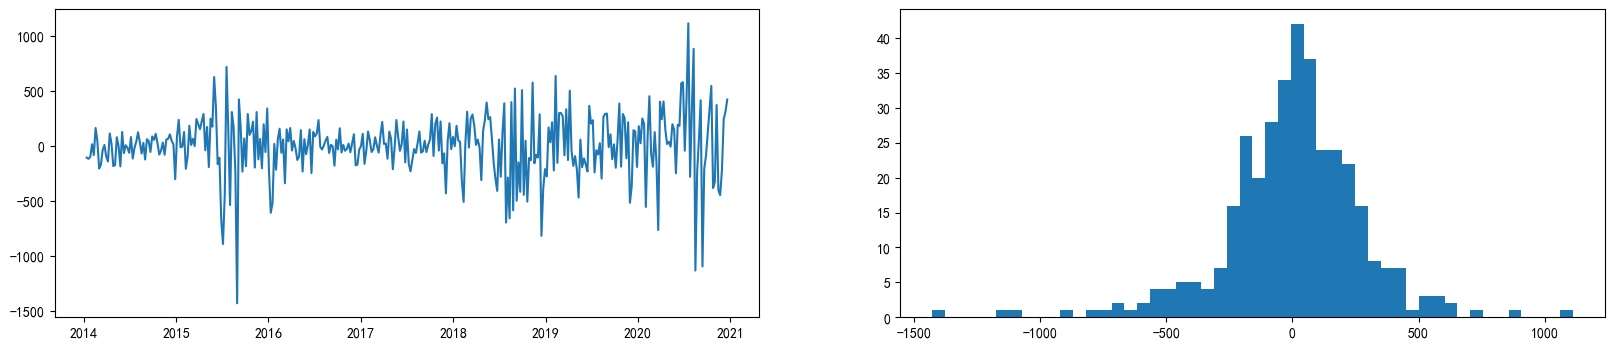

In [14]:

#可视化


fig, axes = plt.subplots(1,2,figsize = (20,4))
axes[0].plot(model.resid,label = "Model Residual")
axes[1].hist(model.resid,bins = 50, normed=True)
sns.kdeplot(model.resid,shade=False)
axes[0].set_xlabel("DateTime",fontsize=16)
axes[0].set_title("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axes[1].set_xlabel("Residual",fontsize=16)
axes[1].set_title("")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.subplots_adjust(wspace=0.1)
plt.savefig("./output/Residual.png",dpi=500, bbox_inches = "tight")
plt.show()

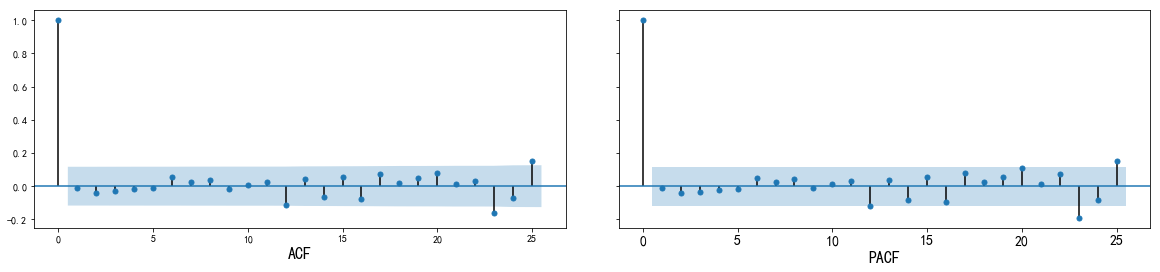

In [47]:
x = sm.stats.durbin_watson(model.resid.values)


#查看acf与pacf确定q和p
fig, axes = plt.subplots(1,2, sharey=True,figsize = (20,4))
plot_acf(model.resid, ax=axes[0])
plot_pacf(model.resid, ax=axes[1])
axes[0].set_xlabel("ACF",fontsize=16)
axes[0].set_title("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axes[1].set_xlabel("PACF",fontsize=16)
axes[1].set_title("")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.subplots_adjust(wspace=0.1)
plt.savefig("./output/residual_acf_pacf.png",dpi=500, bbox_inches = "tight")
plt.show()

In [48]:
r,q,p = sm.tsa.acf(model.resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
test_stochastic2 = round(table.set_index('lag'),3)
test_stochastic2

# def test_stochastic(ts,lag):
#     p_value = acorr_ljungbox(ts, lags=lag, boxpierce=False) #lags可自定义
#     return pd.DataFrame(p_value,index=("Test Value","P Value")).T
# test_stochastic2 = test_stochastic(model.resid,24)
# test_stochastic2

# 从上面的分析结果中可以看到，延迟6阶的p值为<0.05，因此可以拒绝原假设，认为该序列不是白噪声序列。

,AC,Q,Prob(>Q)
lag,,,
1.0,-0.014,0.054,0.816
2.0,-0.039,0.484,0.785
3.0,-0.031,0.757,0.860
4.0,-0.019,0.862,0.930
5.0,-0.013,0.909,0.970
6.0,0.053,1.722,0.943
7.0,0.026,1.914,0.964
8.0,0.036,2.283,0.971
9.0,-0.015,2.347,0.985


Train RMSE: 85.1396
Test RMSE: 241.1194


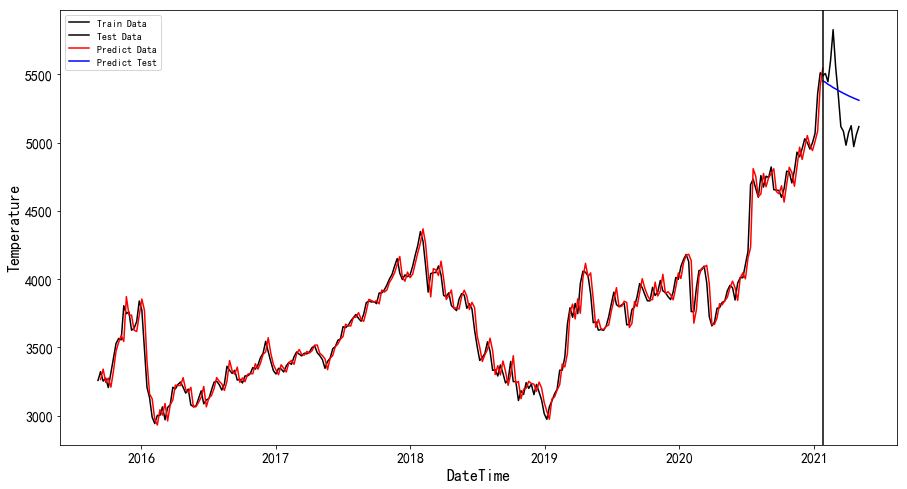

In [52]:
predict_train = model.predict(typ='levels')
# predict_test = model.forecast(int(len(data)*0.15))[0]
predict_test = pd.Series(model.forecast(int(len(data)*0.05+1))[0],index=test_data.index)

#可视化
# 绘制时序图

fig = plt.figure(figsize=(15,8))
plt.plot(train_data,"black",label="Train Data")
plt.plot(test_data,"black",label="Test Data")
plt.plot(predict_train,"red",label = "Predict Data")
plt.plot(predict_test,"blue",label = "Predict Test")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("DateTime", fontsize = 16)
plt.ylabel("Temperature", fontsize = 16)
plt.axvline(x=index,ls="-",c="black")#添加垂直直线
plt.legend(loc="best")
plt.savefig("output/PredictResultAll.png", dpi = 500, format = "png", bbox_inches = "tight")

print('Train RMSE: %.4f'% np.sqrt(np.sum((predict_train-train_data)**2)/train_data.size))
print('Test RMSE: %.4f'% np.sqrt(np.sum((predict_test-test_data)**2)/test_data.size))

plt.show()

In [57]:
error = pd.DataFrame({"Real Data":test_data,"Predict Data":predict_test,"Predict Residual":predict_test-test_data})


with pd.ExcelWriter("./output/df_result.xls") as writer:
    test_stochastic1.to_excel(writer,sheet_name="stochastic1",index=True)
    table1.to_excel(writer,sheet_name="table1")
    table2.to_excel(writer,sheet_name="table2")
    table3.to_excel(writer,sheet_name="table3")
    order_result.to_excel(writer,sheet_name="order_result",index=False)
    test_stochastic2.to_excel(writer,sheet_name="stochastic2",index=True)
    error.to_excel(writer,sheet_name="error",index=True)